# Scraping Data from Twitter Using Tweepy


In [ ]:
# Importing Libraries
import tweepy
import csv
import time
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from textblob import TextBlob
import matplotlib.pyplot as plt

# Importing Scikit-learn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, auc
)

# Importing Other Libraries
import numpy as np
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


# **Twitter API Authentication and Tweet Fetching**

This script demonstrates how to use the **Tweepy** library to interact with the Twitter API. It fetches recent tweets based on a query and saves them to a CSV file. Below is an explanation of how the script works.

---

## **1. API Authentication**
The script uses a **Bearer Token** to authenticate with the Twitter API. This token, provided by Twitter, grants access to interact with the API. A Tweepy `Client` object is initialized to facilitate these interactions.

---

## **2. Function to Fetch and Save Tweets**
The script includes a function to:
1. **Search for Tweets**: It uses the Twitter search API to fetch recent tweets matching a specified query.
2. **Save Tweets to a CSV**: It writes the fetched tweet data (timestamp and text) into a CSV file.

### **How It Works:**
- **Query Parameter**: This is the search term used to find relevant tweets.
- **CSV File Handling**: The tweets are saved in append mode, so existing data in the file isn't overwritten. If the file is empty, it creates headers (`created_at` and `text`).
- **Loop Through Tweets**: Each tweet's timestamp and text are extracted and saved into the file.

---

## **3. Error Handling**
The script handles potential issues during execution:
1. **Rate Limit Handling**: If the rate limit is exceeded, the script pauses for 15 minutes and retries the operation.
2. **General Errors**: Other errors from the Tweepy library are caught and displayed for debugging.

---

## **4. Example Query**
The script demonstrates fetching tweets about **stocks** using the search query `"stocks -is:retweet"`. This query fetches tweets containing the word *stocks* while excluding retweets.

---



In [ ]:
# Twitter API authentication
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAANhDxQEAAAAACoRl5y8fKfEwtf6HuLejjeVmde4%3D44WCFpaO906LtQcWNCQ2eQBsQPERH44NgAXTutFORFzJl4Hvwb"  # Replace with your actual bearer token
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Function to fetch and save tweets
def fetch_and_save_tweets(query, filename="tweets.csv", max_results=100):
    try:
        # Fetch tweets using the search API
        tweets = client.search_recent_tweets(query=query, max_results=max_results, tweet_fields=["created_at", "text"])
        
        # Open file in append mode to collect tweets over time
        with open(filename, mode="a", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            # If the file is empty, write headers
            if file.tell() == 0:
                writer.writerow(["created_at", "text"])
                
            # Write tweet data to file
            for tweet in tweets.data:
                writer.writerow([tweet.created_at, tweet.text])
        
        print(f"Saved {len(tweets.data)} tweets to {filename}")
    
    except tweepy.TooManyRequests as e:
        # Handle rate limit exceeded error
        print(f"Rate limit exceeded. Waiting for 15 minutes...")
        time.sleep(15 * 60)  # Wait for 15 minutes before retrying
        fetch_and_save_tweets(query, filename, max_results)  # Retry fetching tweets

    except tweepy.TweepyException as e:
        # Handle other Tweepy errors
        print(f"An error occurred: {e}")

# Fetch tweets about stocks
fetch_and_save_tweets("stocks -is:retweet", filename="tweets.csv")


Saved 99 tweets to tweets.csv


# **Tweet Preprocessing Script**

This script processes raw tweets collected in a CSV file to clean, preprocess, and filter the data for further analysis.

---

## **Steps Explained**

### **1. Load the Dataset**
The script reads the CSV file containing tweets into a pandas DataFrame:
- Removes duplicate tweets by checking the `text` column.
- Drops rows with missing data in the `text` column.

---

### **2. Clean the Text**
A custom function `clean_text()` is defined to:
- Remove URLs, mentions (e.g., `@user`), hashtags (e.g., `#topic`), and special characters.
- Convert all text to lowercase to ensure consistency.

The cleaned text is stored in a new column, `cleaned_text`.

---

### **3. Tokenization and Lemmatization**
To prepare the text for analysis:
1. **Tokenization**: Splits sentences into individual words (tokens).
2. **Stopword Removal**: Filters out common words like *"and", "the",* etc., using NLTK's predefined list of English stopwords.
3. **Lemmatization**: Reduces words to their root form (e.g., *running → run*).

This process is performed using the `preprocess_text()` function, and the output is stored in a new column, `processed_text`.

---

### **4. Filter Non-English Tweets (Optional)**
To ensure the dataset is purely English, the `is_english()` function checks each tweet's language using the **LangDetect** library:
- Tweets detected as non-English are filtered out.

---

### **5. Save the Processed Data**
After preprocessing, the cleaned dataset is saved to a new CSV file named `cleaned_tweets.csv`.

---

## **Key Features**
1. **Duplicate Removal**: Ensures unique tweets.
2. **Text Cleaning**: Removes unnecessary elements (links, special characters, etc.).
3. **Preprocessing**: Tokenization, stopword removal, and lemmatization for efficient text analysis.
4. **Language Filtering**: Keeps only English tweets for better consistency in analysis.

---

## **Output**
The script generates a file called `cleaned_tweets.csv` containing:
- `text`: Original tweet content.
- `cleaned_text`: Text after basic cleaning.
- `processed_text`: Fully processed text ready for analysis.



In [ ]:
# Read the CSV file
df = pd.read_csv("tweets.csv")

# Remove duplicates
df = df.drop_duplicates(subset="text", keep="first")

# Handle missing data
df = df.dropna(subset=["text"])

# Define a function to clean the text
def clean_text(text):
    # Remove links, mentions, hashtags, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()  # Convert to lowercase
    return text

# Clean the text
df["cleaned_text"] = df["text"].apply(clean_text)

# Tokenize and remove stopwords
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["processed_text"] = df["cleaned_text"].apply(preprocess_text)

# Optional: Filter out non-English tweets
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

df = df[df["processed_text"].apply(is_english)]

# Save the processed data
df.to_csv("cleaned_tweets.csv", index=False)
print("Data cleaned and saved to cleaned_tweets.csv")


Data cleaned and saved to cleaned_tweets.csv




# **Sentiment Analysis on Tweets**

This script performs sentiment analysis on a cleaned dataset of tweets, assigns sentiment scores, and categorizes tweets as **Positive**, **Negative**, or **Neutral**. The results are saved to a CSV file and visualized.

---

## **Steps Explained**

### **1. Load the Cleaned Data**
The script begins by loading the preprocessed dataset (`cleaned_tweets.csv`) into a pandas DataFrame.

---

### **2. Calculate Sentiment Polarity**
- **Sentiment Polarity**: A numeric value between `-1` and `1` is computed for each tweet using the **TextBlob** library:
  - Positive values indicate positive sentiment.
  - Negative values indicate negative sentiment.
  - A value of `0` indicates neutral sentiment.
  
The function `get_sentiment()` calculates the polarity for each tweet and adds it as a new column, `sentiment`.

---

### **3. Categorize Sentiment**
Tweets are categorized into three groups based on their polarity score:
- **Positive**: Polarity > 0.
- **Negative**: Polarity < 0.
- **Neutral**: Polarity = 0.

The script uses the `categorize_sentiment()` function to assign a sentiment category to each tweet, stored in the column `sentiment_category`.

---

### **4. Save the Results**
The updated dataset, including the sentiment polarity and categories, is saved to a new file named `tweets_with_sentiment.csv`.

---

### **5. Visualize Sentiment Distribution**
- The script calculates the count of tweets in each sentiment category using `value_counts()`.
- A bar chart is generated to display the sentiment distribution:
  - Green for Positive tweets.
  - Red for Negative tweets.
  - Blue for Neutral tweets.
- The chart includes labeled axes and a title for clarity.

---

## **Output**
- **CSV File**: `tweets_with_sentiment.csv` containing:
  - `processed_text`: Preprocessed tweet text.
  - `sentiment`: Sentiment polarity score.
  - `sentiment_category`: Sentiment classification (Positive, Negative, Neutral).
  
- **Visualization**: A bar chart showing the distribution of tweets across sentiment categories.

---

## **Key Features**
1. **Sentiment Analysis**: Uses TextBlob to assign polarity scores.
2. **Categorization**: Classifies tweets into distinct sentiment groups.
3. **Visualization**: Provides a graphical summary of sentiment distribution.


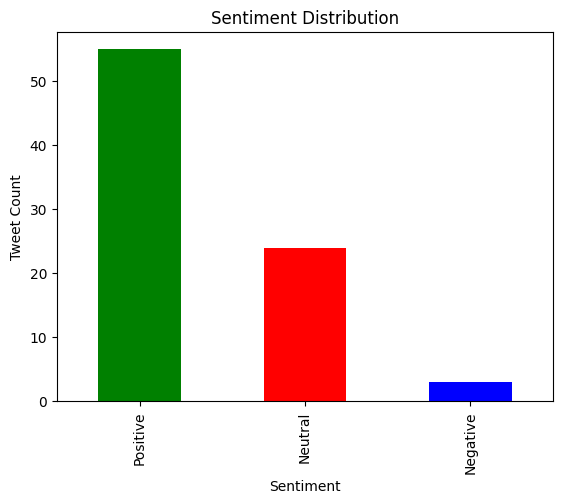

In [ ]:
# Load the cleaned data
df = pd.read_csv("cleaned_tweets.csv")

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Add sentiment polarity to the DataFrame
df["sentiment"] = df["processed_text"].apply(get_sentiment)

# Categorize sentiment
def categorize_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_category"] = df["sentiment"].apply(categorize_sentiment)

# Save sentiment results
df.to_csv("tweets_with_sentiment.csv", index=False)

# Visualize sentiment distribution
sentiment_counts = df["sentiment_category"].value_counts()
sentiment_counts.plot(kind="bar", color=["green", "red", "blue"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()




# **Topic Modeling with Latent Dirichlet Allocation (LDA)**

This script uses **Latent Dirichlet Allocation (LDA)**, a popular topic modeling technique, to identify underlying topics in a set of preprocessed tweets. The text is vectorized using **CountVectorizer**, and LDA is applied to discover the top topics.

---

## **Steps Explained**

### **1. Vectorize the Text for Topic Modeling**
The script starts by vectorizing the preprocessed text using **CountVectorizer**:
- **max_df=0.9**: Ignores words that appear in more than 90% of the documents, removing overly common terms.
- **min_df=10**: Only includes words that appear in at least 10 documents, filtering out very rare terms.
- **stop_words="english"**: Removes common English stopwords like *"the", "and", "to"*.

The **Document-Term Matrix (DTM)** is created, where rows represent documents (tweets) and columns represent terms (words). The values in the matrix indicate the frequency of each term in the corresponding document.

---

### **2. Fit the LDA Model**
**Latent Dirichlet Allocation (LDA)** is then applied to the document-term matrix:
- **n_components=5**: Specifies the number of topics to identify (5 in this case).
- **random_state=42**: Ensures reproducibility of the results.

LDA is a probabilistic model that identifies patterns in the document-term matrix, discovering latent topics that are reflected in the words and their frequencies.

---

### **3. Display the Topics**
After fitting the LDA model, the script displays the top words for each topic:
- The `lda.components_` attribute contains the topic-word distributions.
- For each topic, the script retrieves the 10 most significant words by sorting the word weights and selecting the highest.

Each topic is represented by a list of words that best describe it.

---

## **Output**
The output includes:
- A list of the **top 10 words** for each of the **5 topics** identified by LDA.

For example, the output might look like this:
```
Topic 1:
['stock', 'market', 'investment', 'growth', 'company', 'price', 'trading', 'financial', 'share', 'profit']

Topic 2:
['technology', 'data', 'cloud', 'AI', 'software', 'innovation', 'company', 'development', 'tech', 'digital']
...
```

---

## **Key Features**
1. **Text Vectorization**: Uses **CountVectorizer** to transform the text data into a numerical format suitable for topic modeling.
2. **Topic Modeling**: **LDA** is used to discover hidden topics in the dataset.
3. **Interpretation**: Displays the top words for each topic, making it easy to interpret the underlying themes in the text.


In [ ]:
# Vectorize the text for topic modeling
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words="english")
dtm = vectorizer.fit_transform(df["processed_text"])

# Fit LDA Model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])


Topic 1:
['profit', 'analyst', 'investment', 'week', 'followed', 'advice', 'thank', 'money', 'bought', 'know']
Topic 2:
['profit', 'investment', 'analyst', 'week', 'followed', 'advice', 'thank', 'money', 'bought', 'know']
Topic 3:
['try', 'guy', 'bought', 'followed', 'advice', 'amazing', 'think', 'trade', 'accurate', 'follow']
Topic 4:
['new', 'came', 'unique', 'analysis', 'gave', 'perspective', 'insight', 'week', 'analyst', 'investment']
Topic 5:
['investment', 'analyst', 'week', 'followed', 'advice', 'profit', 'bought', 'thank', 'money', 'know']




# **Stock Mention Frequency Analysis**

This script analyzes the frequency of mentions for specific stocks in a dataset of tweets. It checks for the presence of certain keywords (e.g., **TSLA**, **AAPL**) in the text and visualizes how often they appear.

---

## **Steps Explained**

### **1. Define Keywords for Stock Mentions**
The script defines a list of **keywords** that represent the stocks to track. In this example, the list contains:
- `tesla`
- `apple`
- `stock`
- `market`

These keywords are used to search for mentions within the `processed_text` of the tweets.

---

### **2. Check for Mentions of Each Keyword**
For each keyword in the list:
- The `str.contains()` method is used to check if the keyword appears in each tweet's text (`processed_text`).
  - **case=False**: Makes the search case-insensitive, so it will match "Tesla" or "tesla".
  - **regex=True**: Allows for flexible matching using regular expressions.
- The result is converted into binary values (0 or 1) using `astype(int)`:
  - **1** if the keyword is found in the tweet.
  - **0** if the keyword is not found.

A new column is created for each keyword in the DataFrame, named `{keyword}_mentions`.

---

### **3. Summarize Keyword Mentions**
The script sums up the mentions for each keyword across all tweets:
- **mention_counts**: A pandas series that contains the total number of mentions for each keyword.
- It selects the columns that store the keyword mention data and uses `sum()` to count how many times each keyword was mentioned.

---

### **4. Visualize the Results**
The script generates a **bar chart** using **matplotlib**:
- The x-axis represents the keywords (stocks).
- The y-axis represents the total count of mentions for each keyword.
- The bars are colored in **sky blue** to enhance readability.

---

## **Output**
The output includes:
1. **A bar chart** displaying the frequency of mentions for each stock keyword (e.g., Tesla, Apple).
2. **Mention Count**: The total number of mentions for each keyword across all tweets.

---

## **Key Features**
1. **Keyword Mention Tracking**: Tracks mentions of specific stock-related keywords in tweets.
2. **Data Summarization**: Summarizes the frequency of each keyword across the dataset.
3. **Visualization**: Displays the frequency of mentions in a clear and simple bar chart.


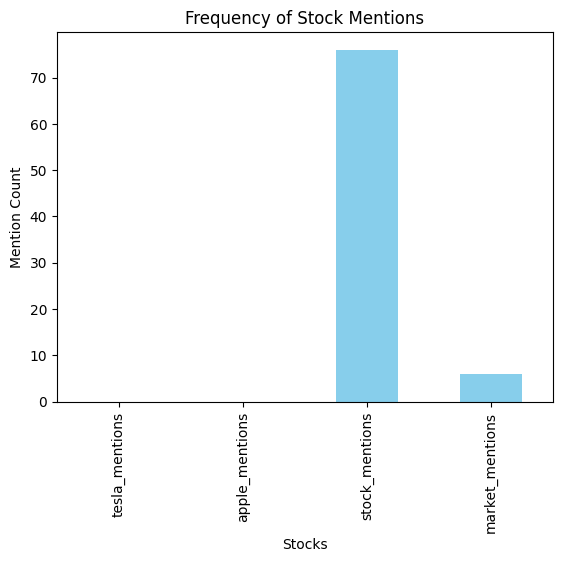

In [5]:
# Frequency of mentions of specific stocks (e.g., TSLA, AAPL)
keywords = ["tesla", "apple", "stock", "market"]
for keyword in keywords:
    df[f"{keyword}_mentions"] = df["processed_text"].str.contains(keyword, case=False, regex=True).astype(int)

# Summarize keyword mentions
mention_counts = df[[f"{keyword}_mentions" for keyword in keywords]].sum()
mention_counts.plot(kind="bar", color="skyblue")
plt.title("Frequency of Stock Mentions")
plt.xlabel("Stocks")
plt.ylabel("Mention Count")
plt.show()




# **WordCloud Generation for Tweet Analysis**

This script generates a **WordCloud** to visualize the most frequent words in a collection of tweets. A WordCloud is a graphical representation where the size of each word corresponds to its frequency in the dataset.

---

## **Steps Explained**

### **1. Combine All Tweets into a Single String**
- The script starts by combining all the preprocessed tweets (stored in the `processed_text` column) into a single string. This is done using:

  This step creates one large string containing the text of all the tweets, which is necessary for generating the WordCloud.

---

### **2. Generate the WordCloud**
- **WordCloud** is generated using the `WordCloud` class from the **wordcloud** library:
  - **width=800, height=400**: Specifies the size of the WordCloud.
  - **background_color="white"**: Sets the background color of the WordCloud to white.
  - **colormap="viridis"**: Uses the "viridis" color scheme for the WordCloud, which gives a visually appealing gradient.

The `generate(all_text)` function creates the WordCloud based on the word frequencies in the combined text.

---

### **3. Display the WordCloud**
- The generated WordCloud is displayed using **matplotlib**:
  - The `imshow()` function is used to display the image.
  - `interpolation="bilinear"` makes the image smoother.
  - The `axis("off")` hides the axis for a cleaner presentation.
  - A title ("WordCloud of Frequent Words") is added to the image.

---

## **Output**
The output is a **WordCloud image** that visually represents the most frequent words in the dataset of tweets:
- The larger the word in the cloud, the more frequently it appears in the text.
- This helps to quickly identify prominent themes or keywords from the tweets.

---

## **Key Features**
1. **Text Aggregation**: Combines all the tweet text into one string for analysis.
2. **WordCloud Visualization**: Creates a visually appealing WordCloud to show the most frequent terms.
3. **Customizable Appearance**: Background color and colormap can be adjusted for a better visual effect.


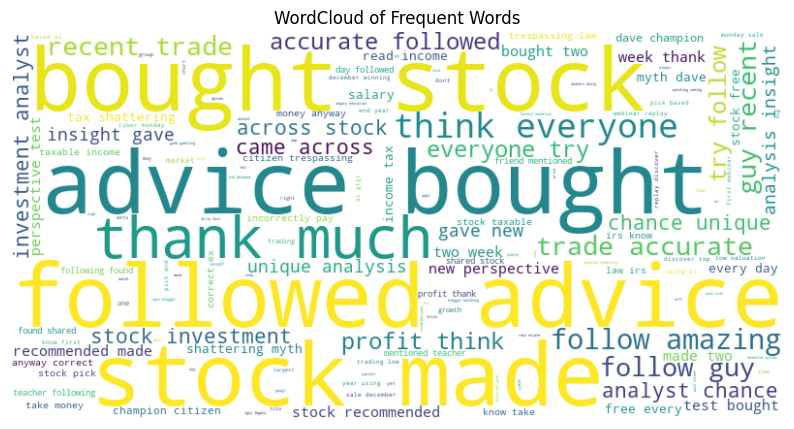

In [ ]:
# Combine all tweets into a single string
all_text = " ".join(df["processed_text"])

# Generate a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_text)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Frequent Words")
plt.show()



# **Preparing Data for Stock Movement Prediction**

This script processes tweet data for use in a machine learning model to predict **stock movements** based on tweet sentiment. The sentiment values are used as features, and the stock movement (up or down) is the target variable.

---

## **Steps Explained**

### **1. Load the Data**
- The script begins by loading the dataset `tweets_with_sentiment.csv` into a pandas DataFrame (`df`), which contains processed tweets along with sentiment scores.
  

### **2. Encode Stock Movements (Target Variable)**
- A new column, `stock_movement`, is created to represent the target variable. This column indicates whether the stock price moved **up** (1) or **down** (0) based on the sentiment of the tweet:
  - **Up (1)**: If the sentiment polarity is positive (`x > 0`).
  - **Down (0)**: If the sentiment polarity is neutral or negative (`x <= 0`).

---

### **3. Define Features and Target**
- **Features (X)**: The model will use two sets of features:
  - **Text Feature (`X_text`)**: Contains the processed text of the tweet.
  - **Sentiment Feature (`X_sentiment`)**: Contains the sentiment polarity score for each tweet.

- **Target (y)**: The target variable is `stock_movement`, which represents whether the stock moved up (1) or down (0).


---

### **4. Split Data into Training and Testing Sets**
- The data is split into **training** and **testing** sets using the `train_test_split()` function from `sklearn.model_selection`:
  - **80% for training** and **20% for testing** (specified by `test_size=0.2`).
  - The data is **stratified** by the target variable (`stratify=y`) to ensure the class distribution (up or down) is similar in both the training and testing sets.

---

## **Output**
- **Training and Testing Data**: The dataset is split into:
  - `X_train_text`, `X_test_text`: Text data for training and testing.
  - `X_train_sent`, `X_test_sent`: Sentiment scores for training and testing.
  - `y_train`, `y_test`: Stock movement labels (up or down) for training and testing.

---

## **Key Features**
1. **Stock Movement Encoding**: Creates a binary target variable (up or down) based on sentiment polarity.
2. **Feature Definition**: Uses tweet text and sentiment scores as features for predicting stock movement.
3. **Data Splitting**: Divides the data into training and testing sets, ensuring a balanced distribution of target classes.


In [8]:
# Load the data
df = pd.read_csv("tweets_with_sentiment.csv")

# Encode stock movements (target variable)
df["stock_movement"] = df["sentiment"].apply(lambda x: 1 if x > 0 else 0)  # 1 for Up, 0 for Down

# Define features (text + sentiment) and target
X_text = df["processed_text"]
X_sentiment = df["sentiment"]
y = df["stock_movement"]

# Split data into training and testing sets
X_train_text, X_test_text, X_train_sent, X_test_sent, y_train, y_test = train_test_split(
    X_text, X_sentiment, y, test_size=0.2, random_state=42, stratify=y
)



# **Text Vectorization and Feature Combination for Stock Movement Prediction**

This script performs text vectorization using **TF-IDF** (Term Frequency-Inverse Document Frequency) and combines the resulting features with sentiment scores to create a feature set for machine learning models.

---

## **Steps Explained**

### **1. Vectorize Text Using TF-IDF**
The script uses **TF-IDF** to convert the tweet text into numerical features that can be used for machine learning:
- **`max_features=5000`**: Limits the number of features (words) to the top 5000, based on their importance across the dataset.
- **`ngram_range=(1, 2)`**: Considers both unigrams (single words) and bigrams (pairs of consecutive words) as features.

The `fit_transform()` method is used on the **training data** (`X_train_text`) to both fit the TF-IDF model and transform the text into a document-term matrix.
The `transform()` method is then applied to the **test data** (`X_test_text`) to convert it using the same TF-IDF model.

---

### **2. Combine Text Features (TF-IDF) with Sentiment Scores**
After vectorizing the text, the next step is to **combine the TF-IDF features** with the **sentiment scores** to form a final feature set. The sentiment scores (`X_train_sent` and `X_test_sent`) are used as an additional feature.

- **`X_train_sent.values.reshape(-1, 1)`**: Reshapes the sentiment values into a 2D array, as required for concatenation.
- **`np.hstack([...])`**: Horizontally stacks the TF-IDF features and sentiment scores, creating a single feature matrix for both training and testing datasets.

---

## **Output**
- **TF-IDF Features**: The tweet text is represented by **5000** features (including unigrams and bigrams).
- **Sentiment Features**: The sentiment polarity scores are added as an extra feature.
- **Combined Feature Set**: Both the **TF-IDF features** and **sentiment scores** are combined to form the final input features for the machine learning model.

---

## **Key Features**
1. **TF-IDF Vectorization**: Converts text data into numerical features based on word importance.
2. **Bigram Consideration**: Includes both individual words and consecutive word pairs as features.
3. **Feature Combination**: Combines TF-IDF features with sentiment scores, making the dataset richer for model training.


In [9]:
# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Combine text features (TF-IDF) with sentiment scores
import numpy as np
X_train = np.hstack([X_train_tfidf.toarray(), X_train_sent.values.reshape(-1, 1)])
X_test = np.hstack([X_test_tfidf.toarray(), X_test_sent.values.reshape(-1, 1)])



# **Hyperparameter Tuning for Logistic Regression and Random Forest**

This section focuses on optimizing the hyperparameters of two machine learning models: **Logistic Regression** and **Random Forest**. Hyperparameter tuning is performed using **GridSearchCV**, which helps find the best combination of parameters based on cross-validation.

---

## **Steps Explained**

### **1. Logistic Regression Hyperparameter Tuning**
- **Objective**: Find the best hyperparameters for the Logistic Regression model.
- **Parameters Tuned**:
  - **C**: Regularization strength, tested with values 0.1, 1, and 10.
  - **solver**: The optimization algorithm, tested with `'liblinear'` and `'lbfgs'`.
- **Method**: GridSearchCV is used to perform 5-fold cross-validation (`cv=5`) for hyperparameter tuning. The `best_estimator_` gives the optimal model after fitting.

### **2. Random Forest Hyperparameter Tuning**
- **Objective**: Find the best hyperparameters for the Random Forest model.
- **Parameters Tuned**:
  - **n_estimators**: Number of trees in the forest, tested with 100, 200, and 300 trees.
  - **max_depth**: Maximum depth of the trees, tested with `None`, 10, and 20.
  - **min_samples_split**: The minimum number of samples required to split an internal node, tested with 2 and 5.
  - **min_samples_leaf**: The minimum number of samples required to be at a leaf node, tested with 1 and 2.
- **Method**: GridSearchCV is again used for 5-fold cross-validation to select the best parameters.

---

## **Output**
- After tuning, both models output the best set of hyperparameters:
  - **Logistic Regression**: Displays the best regularization strength and solver.
  - **Random Forest**: Displays the best combination of the number of trees, depth, and splitting criteria.


In [ ]:
# Logistic Regression Hyperparameter Tuning
logistic_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
logistic_grid = GridSearchCV(LogisticRegression(random_state=42), logistic_params, cv=5)
logistic_grid.fit(X_train, y_train)
logistic_best = logistic_grid.best_estimator_
print("Best Logistic Regression:", logistic_grid.best_params_)

# Random Forest Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best Random Forest:", rf_grid.best_params_)



Best Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


# **Ensemble Learning with Voting Classifier**

This section combines the best models from **Logistic Regression** and **Random Forest** into a **Voting Classifier**. The ensemble approach improves prediction accuracy by leveraging the strengths of multiple models.

---

## **Steps Explained**

### **1. Voting Classifier with Tuned Models**
- **Objective**: Combine the **best Logistic Regression** and **best Random Forest** models into a single ensemble model.
- **Voting Types**:
  - **Hard Voting**: The classifier uses the majority class predicted by each model (the class that gets the most votes). This is a **discrete decision** and is useful when the models output class labels.
  - **Soft Voting**: Uses the predicted probabilities from each classifier and selects the class with the highest average probability (though this isn't used here).

The ensemble model is created by passing the tuned Logistic Regression and Random Forest models to the `VotingClassifier` using hard voting.

### **2. Train the Ensemble Model**
- The `VotingClassifier` is trained on the **training data** using the `fit()` method. This trains all the individual models in the ensemble.

### **3. Predict and Evaluate**
- After training, the ensemble model is used to make predictions on the **test data**.
- The predicted labels are stored in `y_pred_tuned`, which can be further evaluated for accuracy and performance metrics.

---

## **Output**
- The model predicts the class label (stock movement) based on the ensemble decision of both the Logistic Regression and Random Forest models.
- This ensemble model is likely to perform better than individual models by leveraging the combined knowledge from both classifiers.



In [19]:
from sklearn.ensemble import VotingClassifier

# Voting ensemble with tuned models
voting_clf_tuned = VotingClassifier(
    estimators=[
        ('logistic', logistic_best),
        ('random_forest', rf_best),
    ],
    voting='hard'  # 'soft' uses probabilities; 'hard' uses class votes
)

# Train tuned ensemble
voting_clf_tuned.fit(X_train, y_train)

# Predict and evaluate
y_pred_tuned = voting_clf_tuned.predict(X_test)


# **Evaluating the Performance of the Tuned Voting Classifier**

Once the **Tuned Voting Classifier** has made predictions, it's important to assess its performance. This section evaluates the classifier using key metrics like **accuracy** and a **classification report**.

---

## **Steps Explained**

### **1. Accuracy Score**
- **Objective**: Calculate the overall accuracy of the **Tuned Voting Classifier** on the test data.
- **Accuracy** is a measure of how often the classifier's predictions match the actual labels. It is calculated as the ratio of correct predictions to the total number of predictions.

### **2. Classification Report**
- **Objective**: Generate a **classification report** that provides more detailed performance metrics.
- The report includes:
  - **Precision**: The proportion of positive predictions that were correct.
  - **Recall**: The proportion of actual positives that were correctly identified.
  - **F1 Score**: The harmonic mean of precision and recall.
  - **Support**: The number of actual occurrences of each class in the dataset.

The classification report provides a deeper insight into how well the model performs across each class (in this case, stock movement: Up or Down).

---

## **Output**
- The **accuracy score** is printed, showing the overall correctness of the model.
- The **classification report** is displayed, which helps in understanding the classifier’s performance in terms of precision, recall, and F1 score.


In [ ]:
print("Tuned Voting Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned))


Tuned Voting Classifier Performance:
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.91      0.95        11

    accuracy                           0.94        17
   macro avg       0.93      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17




# **Cross-Validation Evaluation for Tuned Voting Classifier**

Cross-validation is a crucial step in assessing the model’s performance in a more robust way. This section demonstrates how to use **Stratified K-Fold Cross-Validation** to evaluate the performance of the **Tuned Voting Classifier** across different metrics.

---

## **Steps Explained**

### **1. Define Cross-Validation Strategy**
- **Stratified K-Fold** is used to ensure that each fold of the data has a proportionate representation of the target classes (stock movement in this case).
- **`n_splits=4`**: The data is split into 4 subsets (folds).
- **`shuffle=True`**: Shuffling of data before splitting to ensure randomness.
- **`random_state=72`**: A seed value to ensure reproducibility of the splits.

### **2. Evaluate the Model Using Cross-Validation**
- **Cross-validation scores** are computed for the **Tuned Voting Classifier** across several evaluation metrics:
  - **Accuracy**: Measures how often the classifier's predictions are correct.
  - **Precision**: Measures the proportion of correct positive predictions (how many predicted positives were actually positive).
  - **Recall**: Measures how many actual positives were correctly identified by the model.
  - **F1 Score**: A harmonic mean of precision and recall, which balances both metrics.
  
Each of these metrics is computed using **cross_val_score**, which runs the classifier through each fold of the training data and evaluates it.

### **3. Print Cross-Validation Metrics**
- The mean and standard deviation of each evaluation metric across the cross-validation folds are printed:
  - **Mean**: The average performance score across all folds.
  - **Standard Deviation**: The variation of scores across different folds, providing insight into how consistent the model’s performance is.

---

## **Output**
- The average and standard deviation of **accuracy**, **precision**, **recall**, and **F1 score** are displayed for the **Tuned Voting Classifier**.

In [25]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=72)

# Evaluate the tuned voting classifier using cross-validation
accuracy_scores = cross_val_score(voting_clf_tuned, X_train, y_train, cv=cv, scoring='accuracy')
precision_scores = cross_val_score(voting_clf_tuned, X_train, y_train, cv=cv, scoring='precision')
recall_scores = cross_val_score(voting_clf_tuned, X_train, y_train, cv=cv, scoring='recall')
f1_scores = cross_val_score(voting_clf_tuned, X_train, y_train, cv=cv, scoring='f1')

# Print cross-validation metrics
print("Cross-Validation Metrics:")
print(f"Accuracy: {np.mean(accuracy_scores):.2f} ± {np.std(accuracy_scores):.2f}")
print(f"Precision: {np.mean(precision_scores):.2f} ± {np.std(precision_scores):.2f}")
print(f"Recall: {np.mean(recall_scores):.2f} ± {np.std(recall_scores):.2f}")
print(f"F1 Score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}")


Cross-Validation Metrics:
Accuracy: 0.94 ± 0.10
Precision: 0.93 ± 0.12
Recall: 1.00 ± 0.00
F1 Score: 0.96 ± 0.07



### **1. Define DNN Model**

The **DNNModel** class defines a neural network with:
- **Input Layer**: Takes the processed text features combined with sentiment scores.
- **Hidden Layers**: Three fully connected (linear) layers with **ReLU activations** and **dropout** to avoid overfitting.
- **Output Layer**: A **single output neuron** with a **Sigmoid** activation function for binary classification (stock movement: up/down).

### **2. Train the Model**

- The **train_model()** function:
  - Converts the training data into **PyTorch tensors**.
  - Defines the **optimizer** (Adam) and **loss function** (Binary Cross-Entropy).
  - Trains the model over multiple epochs, performing forward and backward passes.

### **3. Evaluate the Model**

- The **evaluate_model()** function:
  - Converts validation data to tensors and makes predictions.
  - Uses a **threshold of 0.5** to convert probabilities into binary classifications.
  - Computes the **accuracy** of the model’s predictions on validation data.

### **4. KFold Cross-Validation and Hyperparameter Tuning**

- **KFold Cross-Validation** is used with **5 splits** to evaluate the model's performance and ensure robustness.
  
- **Hyperparameter Grid Search**:
  - The grid search explores different combinations of:
    - **Hidden layer sizes**
    - **Dropout rates**
    - **Learning rates**
    - **Number of epochs**
  - The best performing model from each fold is tracked, and the **best hyperparameters** are selected based on **validation accuracy**.

### **5. Results**

- After completing training and evaluation for all folds, the **average validation accuracy** across all folds is printed, alongside the **best hyperparameters**.

### Key points:
- **Hyperparameter tuning** is crucial to finding the optimal model configuration.
- **KFold cross-validation** ensures the model generalizes well to unseen data, preventing overfitting to a single training/validation split.


In [ ]:
# Parameters for the DNN model
vocab_size = 5000  # As per the TF-IDF configuration
max_sequence_length = X_train_tfidf.shape[1]  # Length of input sequences
batch_size = 32
epochs = 10
embedding_dim = 128

# Define the DNN Model using PyTorch
class DNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super(DNNModel, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_dim, hidden_units[0])
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.fc3 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fc4 = nn.Linear(hidden_units[2], 1)  # Output layer for binary classification
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Define the training function
def train_model(X_train, y_train, hidden_units, dropout_rate, lr, epochs=10):
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    # Create DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Initialize the model
    model = DNNModel(input_dim=X_train.shape[1], hidden_units=hidden_units, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()  # Binary Cross-Entropy loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training the model
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return model

# Define the evaluation function
def evaluate_model(model, X_val, y_val):
    # Convert validation data to tensors
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Make predictions
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor).numpy().flatten()

    val_predictions_binary = (val_predictions > 0.5).astype(int)
    val_accuracy = accuracy_score(y_val, val_predictions_binary)

    return val_accuracy

# KFold Cross-Validation with Hyperparameter Tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'hidden_units': [[512, 256, 128], [1024, 512, 256], [256, 128, 64]],
    'dropout_rate': [0.2, 0.3, 0.5],
    'lr': [0.001, 0.0005, 0.01],
    'epochs': [10, 15]
}

# Store results for each fold
fold_accuracies = []

# Grid Search over hyperparameters
for train_index, val_index in kf.split(X_train_tfidf):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
    
    # Convert sentiment scores to numpy arrays
    X_train_sent_fold = X_train_sent.iloc[train_index].values
    X_val_sent_fold = X_train_sent.iloc[val_index].values
    
    # Combine the TF-IDF features and sentiment features
    X_train_fold_combined = np.hstack([X_train_fold.toarray(), X_train_sent_fold.reshape(-1, 1)])
    X_val_fold_combined = np.hstack([X_val_fold.toarray(), X_val_sent_fold.reshape(-1, 1)])

    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]

    # Hyperparameter tuning (Grid Search)
    best_accuracy = 0
    best_model = None
    best_params = None
    for hidden_units in param_grid['hidden_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for lr in param_grid['lr']:
                for epoch in param_grid['epochs']:
                    print(f"Training model with hidden_units={hidden_units}, dropout_rate={dropout_rate}, lr={lr}, epochs={epoch}")
                    
                    # Train the model
                    model = train_model(X_train_fold_combined, y_train_fold, hidden_units, dropout_rate, lr, epochs=epoch)
                    
                    # Evaluate the model on validation data
                    val_accuracy = evaluate_model(model, X_val_fold_combined, y_val_fold)
                    print(f"Validation Accuracy: {val_accuracy:.4f}")

                    # Update best model if this one is better
                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_model = model
                        best_params = {'hidden_units': hidden_units, 'dropout_rate': dropout_rate, 'lr': lr, 'epochs': epoch}

    print(f"Best validation accuracy: {best_accuracy:.4f}")
    fold_accuracies.append(best_accuracy)

# Average accuracy across folds
average_accuracy = np.mean(fold_accuracies)
print(f"Average Validation Accuracy across folds: {average_accuracy:.4f}")
print(f"Best hyperparameters: {best_params}")


Training model with hidden_units=[512, 256, 128], dropout_rate=0.2, lr=0.001, epochs=10
Validation Accuracy: 0.7692
Training model with hidden_units=[512, 256, 128], dropout_rate=0.2, lr=0.001, epochs=15
Validation Accuracy: 0.8462
Training model with hidden_units=[512, 256, 128], dropout_rate=0.2, lr=0.0005, epochs=10
Validation Accuracy: 0.7692
Training model with hidden_units=[512, 256, 128], dropout_rate=0.2, lr=0.0005, epochs=15
Validation Accuracy: 0.7692
Training model with hidden_units=[512, 256, 128], dropout_rate=0.2, lr=0.01, epochs=10
Validation Accuracy: 1.0000
Training model with hidden_units=[512, 256, 128], dropout_rate=0.2, lr=0.01, epochs=15
Validation Accuracy: 0.8462
Training model with hidden_units=[512, 256, 128], dropout_rate=0.3, lr=0.001, epochs=10
Validation Accuracy: 0.7692
Training model with hidden_units=[512, 256, 128], dropout_rate=0.3, lr=0.001, epochs=15
Validation Accuracy: 0.7692
Training model with hidden_units=[512, 256, 128], dropout_rate=0.3, lr=0

### **1. `plot_roc_curve()` Function**:

This function takes a trained model, validation data (`X_val` and `y_val`), and performs the following tasks:

- **Convert data to PyTorch tensors**: The validation data (`X_val` and `y_val`) is converted into tensors for input to the model.
  
- **Model Prediction**: The model is set to evaluation mode using `model.eval()`. The predictions are generated for the validation data using `model(X_val_tensor)`, and the predicted probabilities (not binary class predictions) are extracted.

- **Compute ROC Curve**:
  - **`roc_curve()`**: This function from scikit-learn computes the **False Positive Rate (FPR)**, **True Positive Rate (TPR)**, and thresholds at various classification probability values.
  - **`auc()`**: This function computes the **Area Under the Curve (AUC)** from the ROC curve, which summarizes the model's ability to distinguish between classes.

- **Plot the ROC Curve**: 
  - The **ROC curve** is plotted with the FPR on the x-axis and the TPR on the y-axis.
  - A **diagonal dashed line** is plotted, representing a random classifier (i.e., no discrimination between classes).
  - The **AUC** is displayed in the plot's legend to summarize the model's performance (values closer to 1 indicate better performance).

### **2. Plotting the ROC Curve**:

After training the model (presumably during the hyperparameter tuning process), the `plot_roc_curve()` function is called with the **best model** and the validation data (`X_val_fold_combined`, `y_val_fold`). This will display the **ROC curve** for the final trained model.

---

### **Considerations**:

- **Use Case**: The ROC curve is particularly useful for understanding how well the classifier discriminates between the positive and negative classes across various thresholds.
  
- **AUC Score**: The **AUC score** ranges from 0 to 1. A higher AUC indicates that the model is better at distinguishing between the classes.

- **Model Selection**: If you are comparing multiple models, the ROC curve and AUC can help you visualize and select the model with the best classification performance.

---

### Example Plot:

Once the function is executed, you'll see a plot with:

- The **True Positive Rate (TPR)** (also known as recall) plotted against the **False Positive Rate (FPR)**.
- The **AUC score** that quantifies the overall performance of the model (closer to 1.0 is better).


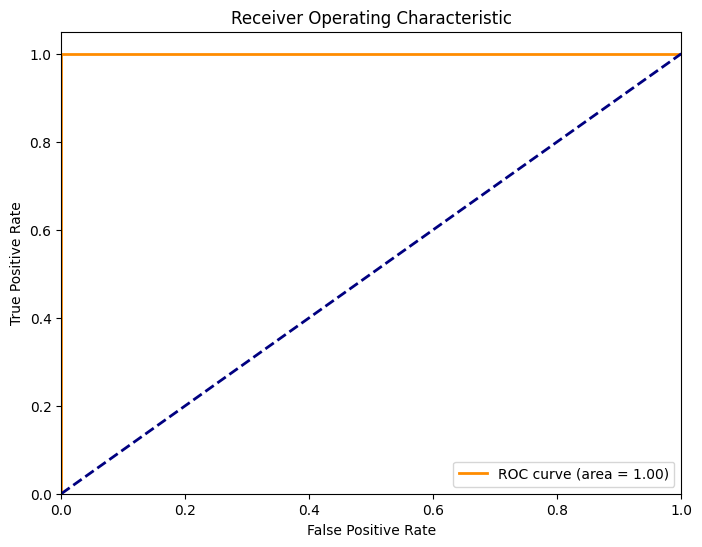

In [ ]:
# Function to plot the ROC curve
def plot_roc_curve(model, X_val, y_val):
    # Convert validation data to tensors
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        y_scores = model(X_val_tensor).numpy().flatten()  # Get predicted probabilities
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Call the function after training and evaluating the model
# Assuming 'best_model' is the trained model from hyperparameter tuning

# Use the validation data (X_val_fold_combined, y_val_fold)
plot_roc_curve(best_model, X_val_fold_combined, y_val_fold)



### **1. Define the Prediction Function**:

The `model_predict` function takes the **input data** and passes it through the trained model to get predictions. It:

- Converts the **input data** into PyTorch tensors.
- Sets the model to **evaluation mode** (`model.eval()`), which is important during inference since it disables operations like dropout that are active during training.
- Uses `torch.no_grad()` to prevent gradients from being calculated, as this speeds up inference and reduces memory usage.
- Returns the model's predictions.

### **2. Select a Sample from the Validation Set**:

A subset of the validation data (`X_val_fold_combined`) is selected for **SHAP interpretation**. In the example, the first 100 rows of the validation set are chosen (`X_val_fold_combined[:100]`).

- You can adjust the size of this subset based on the available computational resources and the size of your dataset. Selecting fewer rows helps speed up SHAP value computation, but more rows may give a more generalizable interpretation.

### **3. Create the SHAP Explainer**:

The SHAP explainer is instantiated using `shap.KernelExplainer`, which is a model-agnostic explainer suitable for any machine learning model, including deep learning models.

- **`model_predict`**: This is the function used to get predictions from the model. SHAP needs this function to simulate how changes in input data affect model predictions.
- **`X_sample`**: This is the subset of input data used to compute SHAP values. The explainer will compute how each feature affects the model's predictions for the provided sample.

### **4. Calculate SHAP Values**:

`explainer.shap_values(X_sample)` computes the **SHAP values** for each feature in the selected sample. The SHAP values represent the contribution of each feature to the final prediction of the model for each instance in the sample.

- **SHAP values** indicate the direction (positive or negative) and magnitude of the contribution each feature makes to the model's predictions.
  
### **5. Plot the SHAP Summary Plot**:

`shap.summary_plot(shap_values, X_sample)` generates a **summary plot**. This is a powerful visualization to understand feature importance and relationships with the target variable:

- **SHAP summary plot**: Shows the **distribution of SHAP values** for each feature across all instances in the selected sample.
  - The **x-axis** represents the SHAP values (which can be positive or negative).
  - The **y-axis** lists the features.
  - **Color** typically represents the feature value (e.g., red for high values, blue for low values).
  - This plot helps you identify which features have the most influence on the model's predictions and whether the effect is positive or negative.

---

### **Considerations**:

- **Interpretability**: SHAP values help you understand how each feature contributes to the model's predictions, offering an interpretable way to explain why a model made a specific prediction for a given instance.
  
- **Computational Complexity**: SHAP value computation can be computationally intensive, especially for large datasets and complex models. In the provided code, using a small subset of the data (`X_sample[:100]`) helps speed up the process.

- **Customizing**: You can adjust the size of `X_sample` or the number of rows used in the SHAP computation to balance between speed and interpretability.

- **Use for Model Debugging**: SHAP can also help in debugging and improving the model by revealing potential issues like data leakage, bias towards certain features, or misinterpretations in feature importance.

---

### **Expected Output**:

- The **SHAP summary plot** will show how each feature (or a combination of features) contributes to the model's prediction.
- Features with higher **SHAP value variance** have a greater impact on the model’s output, while those with smaller SHAP values have a minimal impact.



  0%|          | 0/13 [00:00<?, ?it/s]

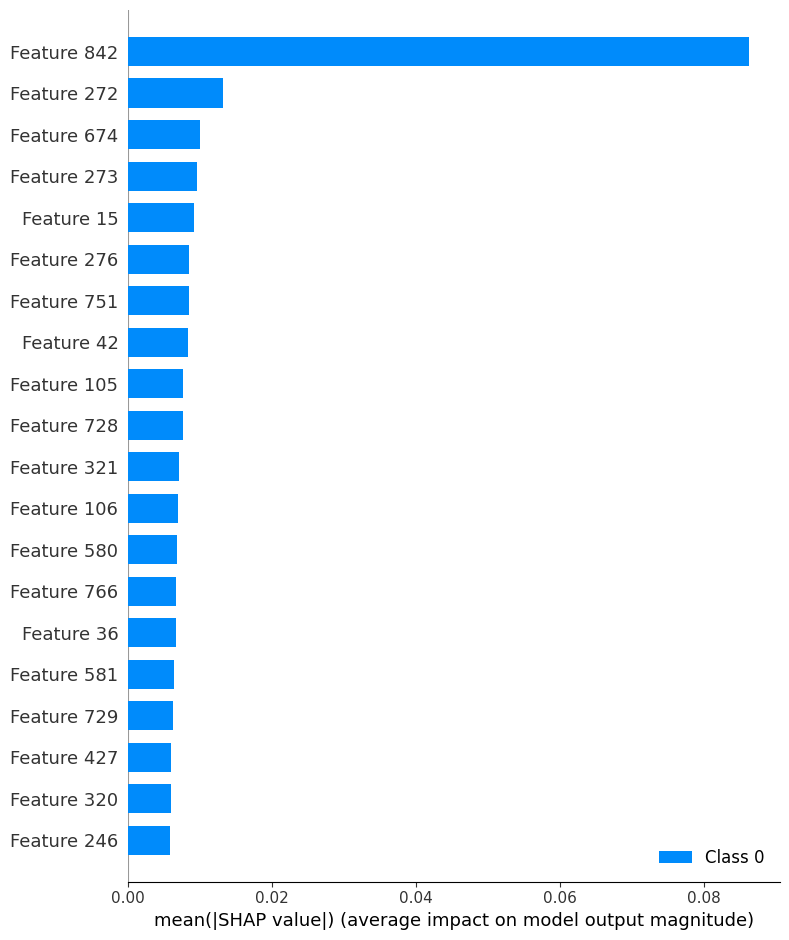

In [ ]:
# Define the prediction function (needed for SHAP)
def model_predict(input_data):
    input_data = torch.tensor(input_data, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(input_data).numpy()
    return predictions

# Select a sample from the validation set for SHAP interpretation
X_sample = X_val_fold_combined[:100]  # Select the first 100 rows for SHAP explanation (adjust as needed)

# Create a SHAP explainer
explainer = shap.KernelExplainer(model_predict, X_sample)

# Calculate SHAP values (you can use a subset of your data for faster computation)
shap_values = explainer.shap_values(X_sample)

# Plot the SHAP values for the first sample
shap.summary_plot(shap_values, X_sample)



### **Steps in the Code**:
1. **Data Setup**:
   - `x = ['Machine Learning', 'Deep Learning']`: This is the list of labels for the x-axis representing the two model categories.
   - `y = [94, 93]`: These are the accuracy values for Machine Learning and Deep Learning, respectively.

2. **Creating the Plot**:
   - `fig, ax = plt.subplots(figsize=(8, 6))`: Creates a figure and axis for plotting the bar chart, setting the size of the figure to 8x6 inches.
   - `bars = ax.bar(x, y, color=['lightblue', 'lightgreen'], alpha=0.7)`: Plots the bars using the `bar()` function, setting colors for the bars and their transparency (`alpha=0.7`).

3. **Adding Accuracy Labels**:
   - A `for` loop is used to iterate over the bars and add the accuracy values above each bar.
   - `ax.text()` is used to place the accuracy labels. It sets the position of the text and formats it to display the value with a '%' sign above each bar.

4. **Customization**:
   - `ax.set_ylabel('Accuracy (%)')`: Adds a label to the y-axis.
   - `ax.set_title('Accuracy Comparison: Machine Learning vs Deep Learning')`: Adds a title to the chart.
   - `ax.grid(True, axis='y', linestyle='--', alpha=0.7)`: Adds a grid to the y-axis for better readability, with a dashed line style.

5. **Display**:
   - `plt.show()`: Displays the plot.
----------------------
### **Output**:
The output is a bar chart with:
- Two bars representing the accuracy of Machine Learning (94%) and Deep Learning (93%).
- Accuracy values displayed above the bars.
- A grid for easier reading of the y-axis values.

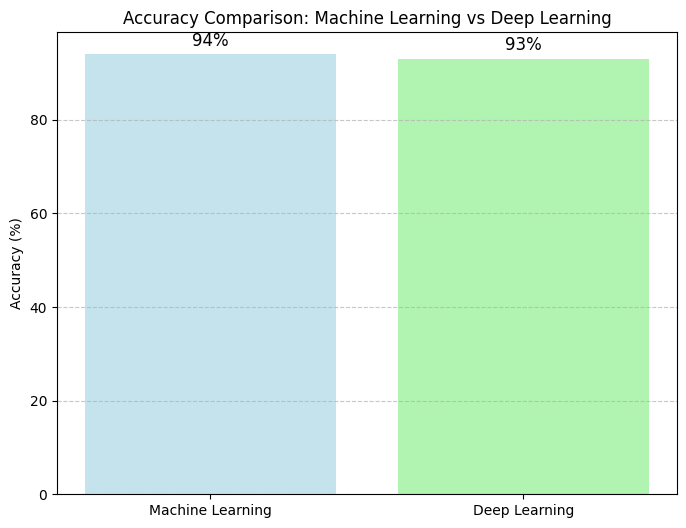

In [ ]:
# Data for the accuracy values
x = ['Machine Learning', 'Deep Learning']
y = [94, 93]  # Accuracy values for Machine Learning and Deep Learning

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart
bars = ax.bar(x, y, color=['lightblue', 'lightgreen'], alpha=0.7)

# Add accuracy labels on top of each bar
for bar, accuracy in zip(bars, y):
    yval = bar.get_height()  # Get the height of the bar
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{accuracy}%', 
            ha='center', va='bottom', fontsize=12)  # Add text above the bar

# Add labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison: Machine Learning vs Deep Learning')

# Add grid, and display the plot
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
